# Part 2: ENSO Phase Prediction

**Goal**: Predict the ENSO phase (Neutral / El Niño / La Niña) 1–3 months ahead using the ONI computed from ERSSTv6 data.

## 1. What is ENSO?

![enso](imgs/enso.png)

The **El Niño–Southern Oscillation (ENSO)** is a climate phenomenon in the Pacific Ocean characterized by periodic warming and cooling of sea surface temperatures.

- **El Niño**: Warmer-than-average SSTs in the central/eastern equatorial Pacific -> droughts in Australia/SE Asia, flooding in South America, warmer winters in North America.
- **La Niña**: Cooler-than-average SSTs in the same region -> opposite effects.
- **Neutral**: Near-average conditions.

ENSO is one of the most important drivers of global climate variability. Predicting it months in advance is a major challenge.

### The Oceanic Niño Index (ONI)
The **ONI** is the standard metric for ENSO monitoring. It is computed as:
1. Average SST anomalies over the **Niño 3.4 region** (5°S–5°N, 170°W–120°W)
2. Apply a **3-month centered running mean** to smooth out noise

ENSO phase is then defined by thresholds on ONI:
- **El Niño**: ONI ≥ +0.5°C
- **La Niña**: ONI ≤ −0.5°C
- **Neutral**: −0.5°C < ONI < +0.5°C

### Our Task
Given the **last 12 months of ONI values**, predict the **ENSO class** for each of the **next 3 months**. This is a **sequence -> classification** problem.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import xarray as xr
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

plt.rcParams["font.family"] = "monospace"

Using device: mps


## 2. Load ERSSTv6 Data

We load the combined dataset that was prepared in Part 2A.

In [2]:
ds = xr.open_dataset("../data/processed/ersstv6_combined.nc")
print(f"Time: {str(ds.time.values[0])[:7]} to {str(ds.time.values[-1])[:7]} ({len(ds.time)} months)")
print(f"Grid: {len(ds.lat)} lat × {len(ds.lon)} lon")
print(f"Variables: {list(ds.data_vars)}")

Time: 1950-01 to 2025-12 (912 months)
Grid: 89 lat × 180 lon
Variables: ['sst', 'ssta']


## 3. Compute the Oceanic Niño Index (ONI)

The ONI is computed in two steps:
1. **Spatial average**: Area-weighted mean SSTA over the Niño 3.4 box (5°S–5°N, 170°W–120°W)
2. **Temporal smoothing**: 3-month centered running mean

In [3]:
# Niño 3.4 region: 5°S-5°N, 170°W-120°W
# In 0-360° longitude: 170°W = 190°, 120°W = 240°
nino34 = ds.ssta.sel(lat=slice(-5, 5), lon=slice(190, 240))

# Step 1: Area-weighted spatial average
weights = np.cos(np.deg2rad(nino34.lat))
nino34_index = nino34.weighted(weights).mean(dim=['lat', 'lon'])

# Step 2: 3-month centered running mean → ONI
oni = nino34_index.rolling(time=3, center=True).mean().dropna('time')

# Convert to pandas
oni_series = oni.to_series()
oni_series.name = 'ONI'

print(f"ONI time series: {len(oni_series)} months")
print(f"Range: {oni_series.index[0].strftime('%Y-%m')} to {oni_series.index[-1].strftime('%Y-%m')}")
print(f"Mean: {oni_series.mean():.3f}, Std: {oni_series.std():.3f}")

ONI time series: 910 months
Range: 1950-02 to 2025-11
Mean: -0.180, Std: 0.802


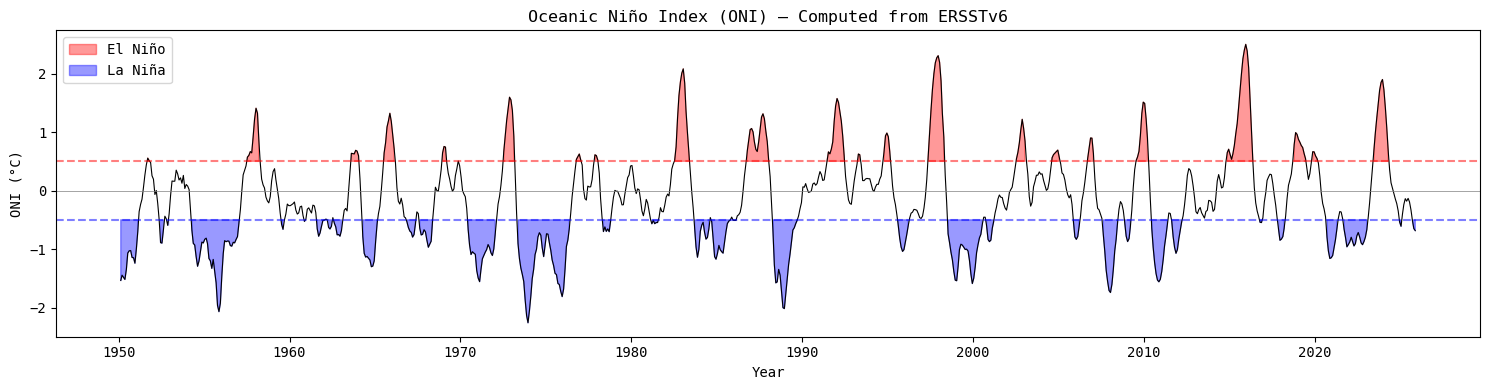

In [4]:
fig, ax = plt.subplots(figsize=(15, 4))

ax.fill_between(oni_series.index, oni_series.values, 0.5,
                where=oni_series.values >= 0.5, color='red', alpha=0.4, label='El Niño')
ax.fill_between(oni_series.index, oni_series.values, -0.5,
                where=oni_series.values <= -0.5, color='blue', alpha=0.4, label='La Niña')
ax.plot(oni_series.index, oni_series.values, color='black', linewidth=0.8)
ax.axhline(0.5, color='red', linestyle='--', alpha=0.5)
ax.axhline(-0.5, color='blue', linestyle='--', alpha=0.5)
ax.axhline(0, color='gray', linewidth=0.5)

ax.set_title('Oceanic Niño Index (ONI) — Computed from ERSSTv6')
ax.set_ylabel('ONI (°C)')
ax.set_xlabel('Year')
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

## 4. Label Each Month by ENSO Phase

Using the standard ONI thresholds:
- **0 = Neutral**: −0.5 < ONI < 0.5
- **1 = El Niño**: ONI ≥ 0.5
- **2 = La Niña**: ONI ≤ −0.5

In [5]:
# Label each month
def oni_to_label(val):
    if val >= 0.5:
        return 1  # El Niño
    elif val <= -0.5:
        return 2  # La Niña
    else:
        return 0  # Neutral

labels = oni_series.apply(oni_to_label).values

phase_names = ['Neutral', 'El Niño', 'La Niña']
for i, name in enumerate(phase_names):
    count = (labels == i).sum()
    print(f"  {name}: {count} months ({100*count/len(labels):.1f}%)")

  Neutral: 409 months (44.9%)
  El Niño: 173 months (19.0%)
  La Niña: 328 months (36.0%)


## 5. Prepare Sequences & DataLoaders

We create a sliding window dataset:
- **Input**: 12 consecutive months of ONI values
- **Target**: ENSO class at lead 1, 2, and 3 months ahead

First, we define the class that will hanlde our dataset for ingestion to the ML model

In [ ]:
class ONIDataset(Dataset):
    def __init__(self, oni_values, labels, seq_len=12, n_leads=3):
        self.seq_len = seq_len
        self.n_leads = n_leads
        self.samples = []
        self.targets = []
        
        for i in range(len(oni_values) - seq_len - n_leads):
            x = oni_values[i : i + seq_len]
            y = [labels[i + seq_len + lead] for lead in range(n_leads)]
            self.samples.append(x)
            self.targets.append(y)
        
        self.samples = torch.tensor(np.array(self.samples), dtype=torch.float32)
        self.targets = torch.tensor(np.array(self.targets), dtype=torch.long)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.targets[idx]

We can now do the split of our dataset. It is a good practise to have 3 sets: training, validation and testing.

In [ ]:
SEQ_LEN = 12  # 12 months of ONI history
N_LEADS = 3   # predict 1, 2, 3 months ahead

# 70/15/15 split

total_samples = len(oni_series) - SEQ_LEN - N_LEADS
train_size = int(0.7 * total_samples)
val_size = int(0.15 * total_samples)
test_size = total_samples - train_size - val_size

train_end = train_size + SEQ_LEN + N_LEADS
val_start = train_size
val_end = val_start + val_size + SEQ_LEN + N_LEADS
test_start = val_start + val_size

train_dataset = ONIDataset(oni_series[:train_end], labels[:train_end], SEQ_LEN, N_LEADS)
val_dataset = ONIDataset(oni_series[val_start:val_end], labels[val_start:val_end], SEQ_LEN, N_LEADS)
test_dataset = ONIDataset(oni_series[test_start:], labels[test_start:], SEQ_LEN, N_LEADS)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples:   {len(val_dataset)}")
print(f"Test samples:  {len(test_dataset)}")
print(f"\nSample input shape: {train_dataset[0][0].shape}  (12 months of ONI)")
print(f"Sample target: {train_dataset[0][1]}  (ENSO class at leads 1,2,3)")

Train samples: 626
Val samples:   134
Test samples:  135

Sample input shape: torch.Size([12])  (12 months of ONI)
Sample target: tensor([2, 0, 0])  (ENSO class at leads 1,2,3)


## 6. Models

We compare three architectures on the 1D ONI sequence:

1. **Linear**: Simplest baseline — weighted sum of 12 ONI values → 3×3 outputs
2. **MLP**: Feedforward network that can learn non-linear patterns
3. **CNN**: 1D Convolutional network

In [7]:
class LinearModel(nn.Module):
    def __init__(self, seq_len, n_classes=3, n_leads=3):
        super().__init__()
        self.heads = nn.ModuleList([nn.Linear(seq_len, n_classes) for _ in range(n_leads)])
    
    def forward(self, x):
        return tuple(head(x) for head in self.heads)


class MLPModel(nn.Module):
    def __init__(self, seq_len, hidden=64, n_classes=3, n_leads=3):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Linear(seq_len, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 32),
            nn.ReLU(),
        )
        self.heads = nn.ModuleList([nn.Linear(32, n_classes) for _ in range(n_leads)])
    
    def forward(self, x):
        features = self.backbone(x)
        return tuple(head(features) for head in self.heads)


class CNN1DModel(nn.Module):
    def __init__(self, seq_len, n_classes=3, n_leads=3):
        super().__init__()
        # Input: (Batch, 1, Seq_Len) -> simple 1D Conv
        self.features = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Flatten()
        )
        
        # Calculate flatten size: 12 -> 6 -> 3.  32 channels * 3 = 96
        # (Assuming seq_len=12)
        self.flatten_dim = 32 * (seq_len // 4) 
        
        self.heads = nn.ModuleList([nn.Linear(self.flatten_dim, n_classes) for _ in range(n_leads)])
    
    def forward(self, x):
        # x: (Batch, Seq_Len) -> need (Batch, Channel, Seq_Len)
        x = x.unsqueeze(1)
        x = self.features(x)
        return tuple(head(x) for head in self.heads)


## 7. Training with PyTorch Lightning

The total loss is the sum of Cross-Entropy losses across all three lead times. We use Early Stopping to prevent overfitting.

In [8]:
class ENSOPredictor(pl.LightningModule):
    def __init__(self, model, learning_rate=0.001):
        super().__init__()
        self.model = model
        self.lr = learning_rate
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def _compute_loss(self, batch):
        x, y = batch
        outputs = self(x)
        loss = sum(self.criterion(outputs[i], y[:, i]) for i in range(len(outputs)))
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._compute_loss(batch)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._compute_loss(batch)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)

### 7.1 Linear Model

In [9]:
# Linear Model
linear_model = LinearModel(SEQ_LEN)
pl_linear = ENSOPredictor(linear_model)

early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=False)

trainer_linear = pl.Trainer(
    max_epochs=50,
    callbacks=[early_stop],
    enable_progress_bar=True,
    logger=False,
    enable_checkpointing=False
)

trainer_linear.fit(pl_linear, train_loader, val_loader)
trained_models = {}
results = {}
trained_models['Linear'] = linear_model

# Evaluate
linear_model.eval()
correct = [0, 0, 0]
total = 0
with torch.no_grad():
    for data, target in test_loader:
        outputs = linear_model(data)
        total += data.size(0)
        for i in range(3):
            _, predicted = torch.max(outputs[i], 1)
            correct[i] += (predicted == target[:, i]).sum().item()

accs = [100 * c / total for c in correct]
results['Linear'] = accs
print(f"Linear Results: Lead 1: {accs[0]:.1f}% | Lead 2: {accs[1]:.1f}% | Lead 3: {accs[2]:.1f}%")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.

  | Name      | Type             | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model     | LinearModel      | 117    | train | 0    
1 | criterion | CrossEntropyLoss | 0      | train | 0    
---------------------------------------------------------------
117       Trainable params
0         Non-trainable params
117       Total params
0.000     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/dangomelon/mambaforge/envs/hidsi_wxclim/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/Users/dangomelon/mambaforge/envs/hidsi_wxclim/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


/Users/dangomelon/mambaforge/envs/hidsi_wxclim/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 20/20 [00:00<00:00, 215.28it/s, train_loss=2.220, val_loss=2.290]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 20/20 [00:00<00:00, 210.66it/s, train_loss=2.220, val_loss=2.290]
Linear Results: Lead 1: 73.3% | Lead 2: 61.5% | Lead 3: 57.8%


### 7.2 MLP Model

In [10]:
# MLP Model
mlp_model = MLPModel(SEQ_LEN)
pl_mlp = ENSOPredictor(mlp_model)

early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=False)

trainer_mlp = pl.Trainer(
    max_epochs=200,
    callbacks=[early_stop],
    enable_progress_bar=True,
    logger=False,
    enable_checkpointing=False
)

trainer_mlp.fit(pl_mlp, train_loader, val_loader)
trained_models['MLP'] = mlp_model

# Evaluate
mlp_model.eval()
correct = [0, 0, 0]
total = 0
with torch.no_grad():
    for data, target in test_loader:
        outputs = mlp_model(data)
        total += data.size(0)
        for i in range(3):
            _, predicted = torch.max(outputs[i], 1)
            correct[i] += (predicted == target[:, i]).sum().item()

accs = [100 * c / total for c in correct]
results['MLP'] = accs
print(f"MLP Results: Lead 1: {accs[0]:.1f}% | Lead 2: {accs[1]:.1f}% | Lead 3: {accs[2]:.1f}%")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.

  | Name      | Type             | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model     | MLPModel         | 3.2 K  | train | 0    
1 | criterion | CrossEntropyLoss | 0      | train | 0    
---------------------------------------------------------------
3.2 K     Trainable params
0         Non-trainable params
3.2 K     Total params
0.013     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
0         Total Flops


Epoch 87: 100%|██████████| 20/20 [00:00<00:00, 159.78it/s, train_loss=1.410, val_loss=1.140]
MLP Results: Lead 1: 91.1% | Lead 2: 83.7% | Lead 3: 71.1%


### 7.3 CNN 1D Model

In [11]:
# CNN 1D Model
cnn_model = CNN1DModel(SEQ_LEN)
pl_cnn = ENSOPredictor(cnn_model)

early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=False)

trainer_cnn = pl.Trainer(
    max_epochs=200,
    callbacks=[early_stop],
    enable_progress_bar=True,
    logger=False,
    enable_checkpointing=False
)

trainer_cnn.fit(pl_cnn, train_loader, val_loader)
trained_models['CNN'] = cnn_model

# Evaluate
cnn_model.eval()
correct = [0, 0, 0]
total = 0
with torch.no_grad():
    for data, target in test_loader:
        outputs = cnn_model(data)
        total += data.size(0)
        for i in range(3):
            _, predicted = torch.max(outputs[i], 1)
            correct[i] += (predicted == target[:, i]).sum().item()

accs = [100 * c / total for c in correct]
results['CNN'] = accs
print(f"CNN Results: Lead 1: {accs[0]:.1f}% | Lead 2: {accs[1]:.1f}% | Lead 3: {accs[2]:.1f}%")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.

  | Name      | Type             | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model     | CNN1DModel       | 2.5 K  | train | 0    
1 | criterion | CrossEntropyLoss | 0      | train | 0    
---------------------------------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode
0         Total Flops


Epoch 108: 100%|██████████| 20/20 [00:00<00:00, 148.90it/s, train_loss=0.899, val_loss=1.210]
CNN Results: Lead 1: 91.1% | Lead 2: 79.3% | Lead 3: 65.9%


## 8. Results Comparison

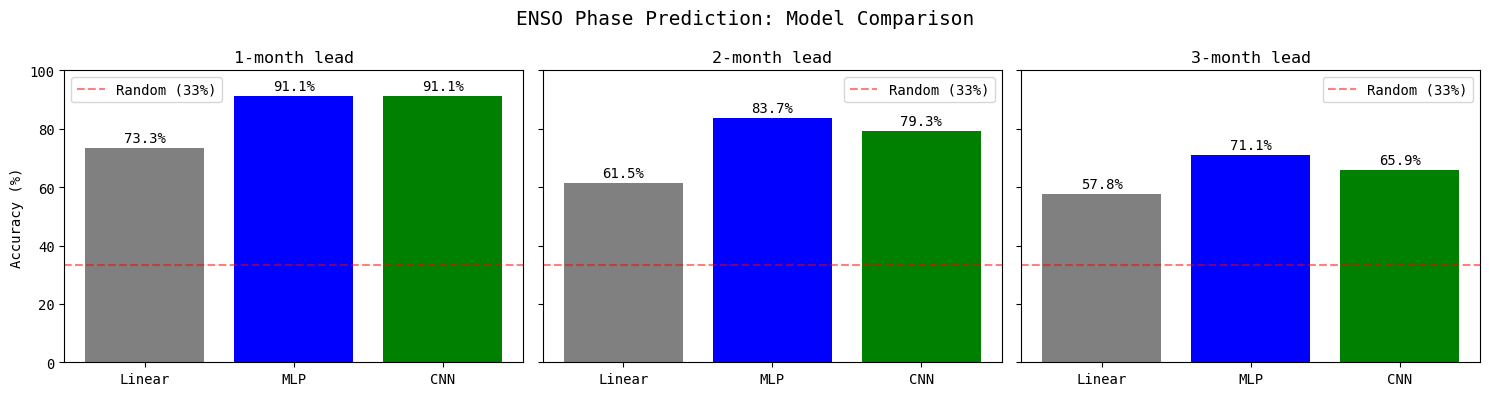

In [12]:
# Bar chart comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
colors = ['gray', 'blue', 'green']
lead_names = ['1-month lead', '2-month lead', '3-month lead']

for i, ax in enumerate(axes):
    model_names = list(results.keys())
    accs = [results[name][i] for name in model_names]
    bars = ax.bar(model_names, accs, color=colors)
    ax.axhline(33.3, color='red', linestyle='--', alpha=0.5, label='Random (33%)')
    ax.set_title(lead_names[i])
    ax.set_ylabel('Accuracy (%)' if i == 0 else '')
    ax.set_ylim(0, 100)
    ax.legend()
    for bar, acc in zip(bars, accs):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{acc:.1f}%', ha='center', va='bottom', fontsize=10)

plt.suptitle('ENSO Phase Prediction: Model Comparison', fontsize=14)
plt.tight_layout()
plt.show()

Best model: MLP


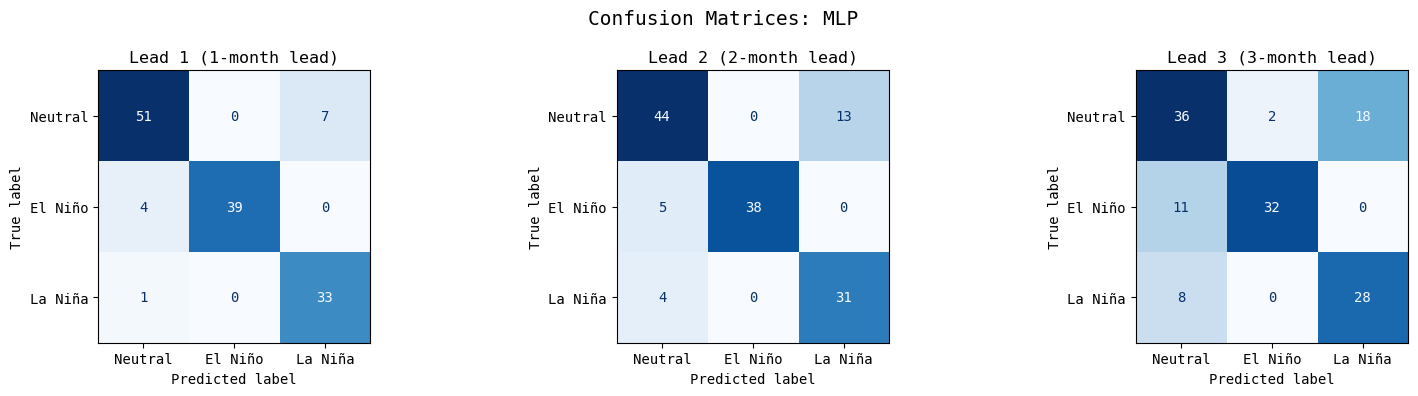

In [13]:
# Confusion matrices for the best model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

best_name = max(results, key=lambda k: sum(results[k]))
best_model = trained_models[best_name]
print(f"Best model: {best_name}")

best_model.eval()
all_preds = [[], [], []]
all_targets = [[], [], []]

with torch.no_grad():
    for data, target in test_loader:
        outputs = best_model(data)
        for i in range(3):
            _, predicted = torch.max(outputs[i], 1)
            all_preds[i].extend(predicted.numpy())
            all_targets[i].extend(target[:, i].numpy())

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
for i, ax in enumerate(axes):
    cm = confusion_matrix(all_targets[i], all_preds[i], labels=[0, 1, 2])
    disp = ConfusionMatrixDisplay(cm, display_labels=phase_names)
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(f"Lead {i+1} ({lead_names[i]})")

plt.suptitle(f'Confusion Matrices: {best_name}', fontsize=14)
plt.tight_layout()
plt.show()

## 9. Live Forecast

Let's use the last 12 months of our ONI time series to predict ENSO for the upcoming months.

In [14]:
# Use the last 12 months of ONI as input
last_12 = oni_series[-SEQ_LEN:]
last_date = oni_series.index[-1]

print(f"Input: ONI from {oni_series.index[-SEQ_LEN].strftime('%Y-%m')} to {last_date.strftime('%Y-%m')}")
print(f"Last 12 ONI values: {np.round(last_12, 2)}")

# Predict
best_model.eval()
with torch.no_grad():
    inp = torch.tensor(last_12.values, dtype=torch.float32).unsqueeze(0)
    outputs = best_model(inp)

# Display forecast
print(f"\n{'='*50}")
print(f"ENSO Forecast (from {best_name} model)")
print(f"{'='*50}")

for i in range(N_LEADS):
    probs = torch.softmax(outputs[i], dim=1)[0]
    pred_class = outputs[i].argmax().item()
    forecast_month = last_date + pd.DateOffset(months=i+1)
    print(f"\n  {forecast_month.strftime('%B %Y')}:")
    for j, name in enumerate(phase_names):
        marker = " ◀" if j == pred_class else ""
        print(f"    {name}: {probs[j]:.1%}{marker}")

Input: ONI from 2024-12 to 2025-11
Last 12 ONI values: time
2024-12-15   -0.54
2025-01-15   -0.61
2025-02-15   -0.40
2025-03-15   -0.24
2025-04-15   -0.14
2025-05-15   -0.18
2025-06-15   -0.13
2025-07-15   -0.19
2025-08-15   -0.33
2025-09-15   -0.51
2025-10-15   -0.65
2025-11-15   -0.69
Name: ONI, dtype: float64

ENSO Forecast (from MLP model)

  December 2025:
    Neutral: 10.7%
    El Niño: 0.0%
    La Niña: 89.3% ◀

  January 2026:
    Neutral: 26.2%
    El Niño: 0.0%
    La Niña: 73.8% ◀

  February 2026:
    Neutral: 39.0%
    El Niño: 0.0%
    La Niña: 61.0% ◀


## 10. Discussion

### Key Takeaways
- **ONI as a feature**: The ONI time series captures the essential ENSO signal — a single number per month computed from gridded SST data
- **Sequence → Classification**: Framing ENSO prediction as classification avoids the difficulties of exact regression
- **Lead time decay**: Accuracy decreases with longer lead times — a fundamental limit of predictability
- **Real-world impact**: ENSO forecasts inform agriculture, disaster preparedness, and water resource management worldwide

### Next Steps
- Use the **full 2D SST maps** instead of just ONI (needs a 2D CNN — more powerful but more complex)
- Try **multi-month input sequences of SST maps** (3D: time × lat × lon)
- Use **WeatherBench2** for a more sophisticated global weather prediction approach

## 11. From 1D to 2D: SST Map Prediction

We now advance to using the full **Sea Surface Temperature (SST) maps** as input, rather than just the simplified ONI index.

We will compare two approaches:
1.  **2D CNN Classifier**: Takes the sequence of 12 SST maps and directly predicts the ENSO class (0, 1, 2).
2.  **U-Net Map Predictor**: Takes the sequence of 12 SST maps and predicts the **Next Month's SST Map**. We then calculate the ONI from the predicted map to determine the ENSO Phase.

In [15]:
# SST Dataset for 2D Maps
class SSTDataset(Dataset):
    def __init__(self, sst_data, labels, seq_len=12, n_leads=3):
        self.seq_len = seq_len
        self.n_leads = n_leads
        # sst_data: (Time, Lat, Lon)
        # Fill NaNs with 0.0 (Land)
        self.sst_data = torch.tensor(np.nan_to_num(sst_data), dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        # Constraints
        max_idx_sst = len(self.sst_data) - self.seq_len - self.n_leads
        max_idx_labels = len(self.labels) - self.seq_len - self.n_leads
        max_idx = min(max_idx_sst, max_idx_labels)
        return max(0, max_idx + 1)

    def __getitem__(self, idx):
        # Input: (Seq_Len, Lat, Lon)
        x = self.sst_data[idx : idx + self.seq_len]
        
        # Target Class: (n_leads)
        target_start = idx + self.seq_len
        target_end = target_start + self.n_leads
        y = self.labels[target_start : target_end]
        
        if len(y) < self.n_leads:
            padding = torch.full((self.n_leads - len(y),), y[-1] if len(y)>0 else 0, dtype=torch.long)
            y = torch.cat([y, padding])
        
        # Target Map Sequence: (n_leads, Lat, Lon)
        y_map = self.sst_data[target_start : target_end]
        
        # Safety check for map
        if len(y_map) < self.n_leads:
             # Pad with last frame
             pad_frames = self.n_leads - len(y_map)
             last_frame = y_map[-1].unsqueeze(0) if len(y_map) > 0 else torch.zeros(1, *self.sst_data.shape[1:])
             padding = last_frame.repeat(pad_frames, 1, 1)
             y_map = torch.cat([y_map, padding])
        
        return x, y, y_map

sst_values = ds.ssta.values
train_dataset_2d = SSTDataset(sst_values[:train_end], labels[:train_end], SEQ_LEN, N_LEADS)
val_dataset_2d = SSTDataset(sst_values[val_start:val_end], labels[val_start:val_end], SEQ_LEN, N_LEADS)
test_dataset_2d = SSTDataset(sst_values[test_start:], labels[test_start:], SEQ_LEN, N_LEADS)

train_loader_2d = DataLoader(train_dataset_2d, batch_size=16, shuffle=True)
val_loader_2d = DataLoader(val_dataset_2d, batch_size=16)
test_loader_2d = DataLoader(test_dataset_2d, batch_size=16)

print(f"2D Sample Shape: {train_dataset_2d[0][0].shape}")

2D Sample Shape: torch.Size([12, 89, 180])


### 11.1 2D CNN Classifier

In [ ]:
class CNN2DModel(nn.Module):
    def __init__(self, seq_len, lat_dim, lon_dim, n_classes=3, n_leads=3, dense_hidden=128):
        super().__init__()
        # Input: (Batch, Seq_Len, Lat, Lon) -> Treat Seq_Len as Channels
        self.features = nn.Sequential(
            nn.Conv2d(seq_len, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten()
        )
        
        # Calculate flat dim dynamically
        with torch.no_grad():
            dummy = torch.zeros(1, seq_len, lat_dim, lon_dim)
            out = self.features(dummy)
            self.flat_dim = out.shape[1]
            
        # Enhanced Fully Connected Block
        self.fc_block = nn.Sequential(
            nn.Linear(self.flat_dim, dense_hidden),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(dense_hidden, dense_hidden // 2),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Heads take input from the last FC layer
        self.heads = nn.ModuleList([nn.Linear(dense_hidden // 2, n_classes) for _ in range(n_leads)])
        
    def forward(self, x):
        x = self.features(x)
        x = self.fc_block(x)
        return tuple(head(x) for head in self.heads)

lat_dim = len(ds.lat)
lon_dim = len(ds.lon)

# Train CNN 2D
cnn2d = CNN2DModel(SEQ_LEN, lat_dim, lon_dim)
pl_cnn2d = ENSOPredictor(cnn2d)

class ENSO2DClassifier(ENSOPredictor):
    def _compute_loss(self, batch):
        x, y, _ = batch # Ignore y_map
        outputs = self(x)
        loss = sum(self.criterion(outputs[i], y[:, i]) for i in range(len(outputs)))
        return loss

pl_cnn2d = ENSO2DClassifier(cnn2d)

early_stop_2d = EarlyStopping(monitor='val_loss', patience=15, mode='min', verbose=False)
trainer_2d = pl.Trainer(max_epochs=200, callbacks=[early_stop_2d], enable_progress_bar=True)
trainer_2d.fit(pl_cnn2d, train_loader_2d, val_loader_2d)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/dangomelon/mambaforge/envs/hidsi_wxclim/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitMode

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/dangomelon/mambaforge/envs/hidsi_wxclim/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/Users/dangomelon/mambaforge/envs/hidsi_wxclim/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


/Users/dangomelon/mambaforge/envs/hidsi_wxclim/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/dangomelon/mambaforge/envs/hidsi_wxclim/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:317: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 15: 100%|██████████| 40/40 [00:00<00:00, 57.27it/s, v_num=20, train_loss=1.400, val_loss=5.820] 


### 11.2 U-Net Classifier (Map -> Class)

In [17]:
class UNetClassifier(nn.Module):
    def __init__(self, in_channels, n_classes=3, n_leads=3, dense_hidden=64):
        super().__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1), nn.BatchNorm2d(out_c), nn.ReLU(),
                nn.Conv2d(out_c, out_c, 3, padding=1), nn.BatchNorm2d(out_c), nn.ReLU()
            )

        # Encoder
        self.enc1 = conv_block(in_channels, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(32, 64)
        self.pool2 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = conv_block(64, 128)
        
        # Decoder (Optional for Classification, but keeping structure for feature richness)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = conv_block(128, 64)
        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec1 = conv_block(64, 32)
        
        # Classification Head
        # We take the Output of Decoder 1 (Original Resolution Features)
        # Or we can take Bottleneck. Let's take Decoder Output for spatial context.
        # Global Average Pooling -> (Batch, 32)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc_block = nn.Sequential(
            nn.Linear(32, dense_hidden),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        self.heads = nn.ModuleList([nn.Linear(dense_hidden, n_classes) for _ in range(n_leads)])

    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        
        b = self.bottleneck(p2)
        
        d2 = self.up2(b)
        if d2.shape != e2.shape: d2 = nn.functional.interpolate(d2, size=e2.shape[2:])
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.dec2(d2)
        
        d1 = self.up1(d2)
        if d1.shape != e1.shape: d1 = nn.functional.interpolate(d1, size=e1.shape[2:])
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.dec1(d1)
        
        # Classification Branch
        out = self.global_pool(d1) # (Batch, 32, 1, 1)
        out = out.view(out.size(0), -1) # (Batch, 32)
        out = self.fc_block(out)
        
        return tuple(head(out) for head in self.heads)

# U-Net is now a Classifier, so we use CrossEntropy
unet = UNetClassifier(in_channels=SEQ_LEN)
pl_unet = ENSO2DClassifier(unet) 

early_stop_unet = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=False)
trainer_unet = pl.Trainer(max_epochs=20, callbacks=[early_stop_unet], enable_progress_bar=True)
trainer_unet.fit(pl_unet, train_loader_2d, val_loader_2d)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.

  | Name      | Type             | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model     | UNetClassifier   | 473 K  | train | 0    
1 | criterion | CrossEntropyLoss | 0      | train | 0    
---------------------------------------------------------------
473 K     Trainable params
0         Non-trainable params
473 K     Total params
1.892     Total estimated model params size (MB)
50        Modules in train mode
0         Modules in 

Epoch 19: 100%|██████████| 40/40 [00:03<00:00, 10.01it/s, v_num=21, train_loss=2.070, val_loss=4.150]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 40/40 [00:04<00:00,  9.89it/s, v_num=21, train_loss=2.070, val_loss=4.150]


Evaluating 2D Models...
CNN2D Results: Lead 1: 62.5% | Lead 2: 53.7% | Lead 3: 52.2%
UNet Results: Lead 1: 34.6% | Lead 2: 33.1% | Lead 3: 33.8%


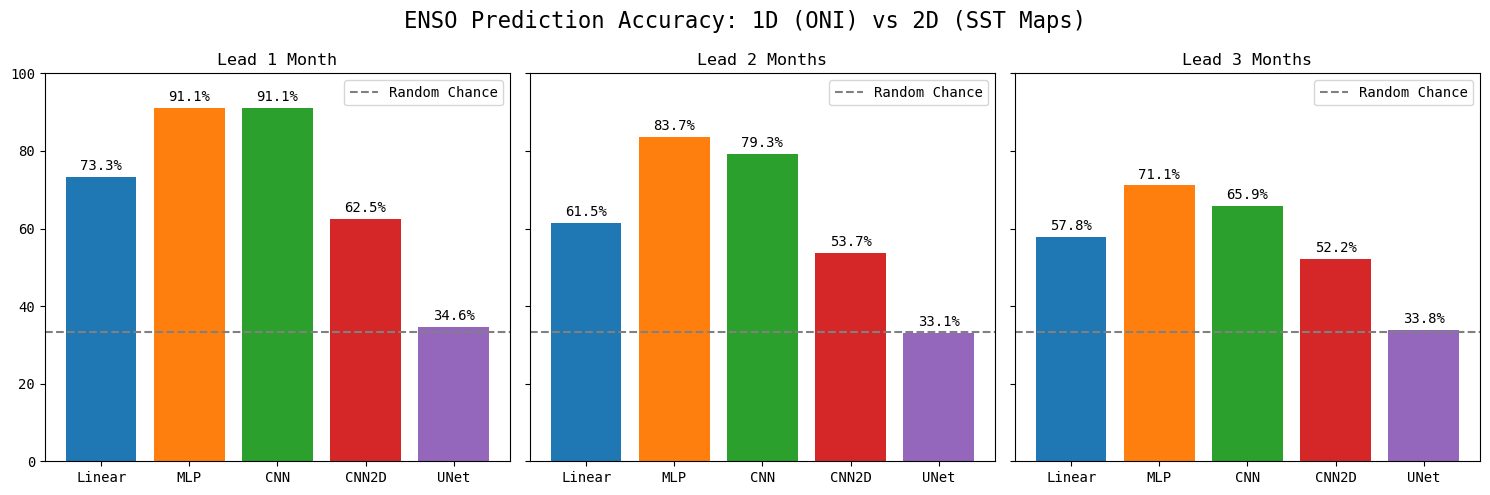

In [18]:
# 11.3 Results Comparison (1D vs 2D Models)
models_2d = {'CNN2D': cnn2d, 'UNet': unet}
results_2d = {}

print("Evaluating 2D Models...")
for name, model in models_2d.items():
    model.eval()
    correct = [0, 0, 0]
    total = 0
    with torch.no_grad():
        for data, target, _ in test_loader_2d: # Ignore y_map
            outputs = model(data)
            total += data.size(0)
            for i in range(3):
                _, predicted = torch.max(outputs[i], 1)
                correct[i] += (predicted == target[:, i]).sum().item()
    
    accs = [100 * c / total for c in correct]
    results_2d[name] = accs
    print(f"{name} Results: Lead 1: {accs[0]:.1f}% | Lead 2: {accs[1]:.1f}% | Lead 3: {accs[2]:.1f}%")

# Plot Comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
lead_names = ['Lead 1 Month', 'Lead 2 Months', 'Lead 3 Months']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'] # Blue, Orange, Green, Red, Purple

# Combine 1D results if available
all_results = results.copy() if 'results' in locals() else {}
all_results.update(results_2d)

model_names = list(all_results.keys())

for i, ax in enumerate(axes):
    accuracies = [all_results[m][i] for m in model_names]
    bars = ax.bar(model_names, accuracies, color=colors[:len(model_names)])
    ax.set_title(lead_names[i])
    ax.set_ylim(0, 100)
    ax.axhline(33.3, color='grey', linestyle='--', label='Random Chance')
    ax.legend()
    
    # Add labels
    for bar, acc in zip(bars, accuracies):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{acc:.1f}%', ha='center', va='bottom')

plt.suptitle("ENSO Prediction Accuracy: 1D (ONI) vs 2D (SST Maps)", fontsize=16)
plt.tight_layout()
plt.show()

### 11.4 U-Net for Map Prediction (Seq2Seq)
Here we use the U-Net architecture to predict the **SST Maps** for the next 3 months, given the past 12 months.

In [19]:
# Enhanced U-Net with Deeper Architecture (up to 256 channels)
class UNetMapModel(nn.Module):
    def __init__(self, in_channels, out_channels=3):
        super().__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1), nn.BatchNorm2d(out_c), nn.ReLU(),
                nn.Conv2d(out_c, out_c, 3, padding=1), nn.BatchNorm2d(out_c), nn.ReLU()
            )

        # Encoder (Contracting Path)
        self.enc1 = conv_block(in_channels, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(32, 64)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = conv_block(64, 128)
        self.pool3 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = conv_block(128, 256)
        
        # Decoder (Expansive Path)
        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec3 = conv_block(256, 128) # 128+128 inputs
        
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = conv_block(128, 64) # 64+64 inputs
        
        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec1 = conv_block(64, 32) # 32+32 inputs
        
        self.final = nn.Conv2d(32, out_channels, 1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)
        
        # Bottleneck
        b = self.bottleneck(p3)
        
        # Decoder
        d3 = self.up3(b)
        # Handle padding/shape mismatch if any due to odd dims
        if d3.shape != e3.shape: d3 = nn.functional.interpolate(d3, size=e3.shape[2:])
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.dec3(d3)
        
        d2 = self.up2(d3)
        if d2.shape != e2.shape: d2 = nn.functional.interpolate(d2, size=e2.shape[2:])
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.dec2(d2)
        
        d1 = self.up1(d2)
        if d1.shape != e1.shape: d1 = nn.functional.interpolate(d1, size=e1.shape[2:])
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.dec1(d1)
        
        return self.final(d1)

class SSTMapPredictor(pl.LightningModule):
    def __init__(self, model, lr=1e-3):
        super().__init__()
        self.model = model
        self.lr = lr
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, _, y_map = batch
        pred_map = self(x)
        loss = self.criterion(pred_map, y_map)
        self.log("train_mse", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, _, y_map = batch
        pred_map = self(x)
        loss = self.criterion(pred_map, y_map)
        self.log("val_mse", loss, prog_bar=True)
        return loss
        
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)

unet_map = UNetMapModel(in_channels=SEQ_LEN, out_channels=N_LEADS)
pl_unet_map = SSTMapPredictor(unet_map)

early_stop_map = EarlyStopping(monitor='val_mse', patience=5, mode='min', verbose=False)
trainer_map = pl.Trainer(max_epochs=20, callbacks=[early_stop_map], enable_progress_bar=True)
trainer_map.fit(pl_unet_map, train_loader_2d, val_loader_2d)


GPU available: True (mps), used: True


Training Enhanced Map Predictor (Deeper U-Net, 256ch)...


TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.

  | Name      | Type         | Params | Mode  | FLOPs
-----------------------------------------------------------
0 | model     | UNetMapModel | 1.9 M  | train | 0    
1 | criterion | MSELoss      | 0      | train | 0    
-----------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.724     Total estimated model params size (MB)
58        Modules in train mode
0         Modules in eval mode
0         Total Flops


Epoch 0: 100%|██████████| 40/40 [00:05<00:00,  6.97it/s, v_num=22, train_mse=0.134, val_mse=0.114]

Metric val_mse improved. New best score: 0.114


Epoch 1: 100%|██████████| 40/40 [00:04<00:00,  9.29it/s, v_num=22, train_mse=0.127, val_mse=0.112]

Metric val_mse improved by 0.001 >= min_delta = 0.0. New best score: 0.112


Epoch 4: 100%|██████████| 40/40 [00:04<00:00,  9.33it/s, v_num=22, train_mse=0.124, val_mse=0.111]

Metric val_mse improved by 0.001 >= min_delta = 0.0. New best score: 0.111


Epoch 5: 100%|██████████| 40/40 [00:04<00:00,  8.75it/s, v_num=22, train_mse=0.107, val_mse=0.110]

Metric val_mse improved by 0.001 >= min_delta = 0.0. New best score: 0.110


Epoch 8: 100%|██████████| 40/40 [00:04<00:00,  8.22it/s, v_num=22, train_mse=0.121, val_mse=0.110]

Metric val_mse improved by 0.000 >= min_delta = 0.0. New best score: 0.110


Epoch 9: 100%|██████████| 40/40 [00:05<00:00,  7.93it/s, v_num=22, train_mse=0.113, val_mse=0.110]

Metric val_mse improved by 0.001 >= min_delta = 0.0. New best score: 0.110


Epoch 14: 100%|██████████| 40/40 [00:04<00:00,  9.27it/s, v_num=22, train_mse=0.103, val_mse=0.118] 

Monitored metric val_mse did not improve in the last 5 records. Best score: 0.110. Signaling Trainer to stop.


Epoch 14: 100%|██████████| 40/40 [00:04<00:00,  9.07it/s, v_num=22, train_mse=0.103, val_mse=0.118]


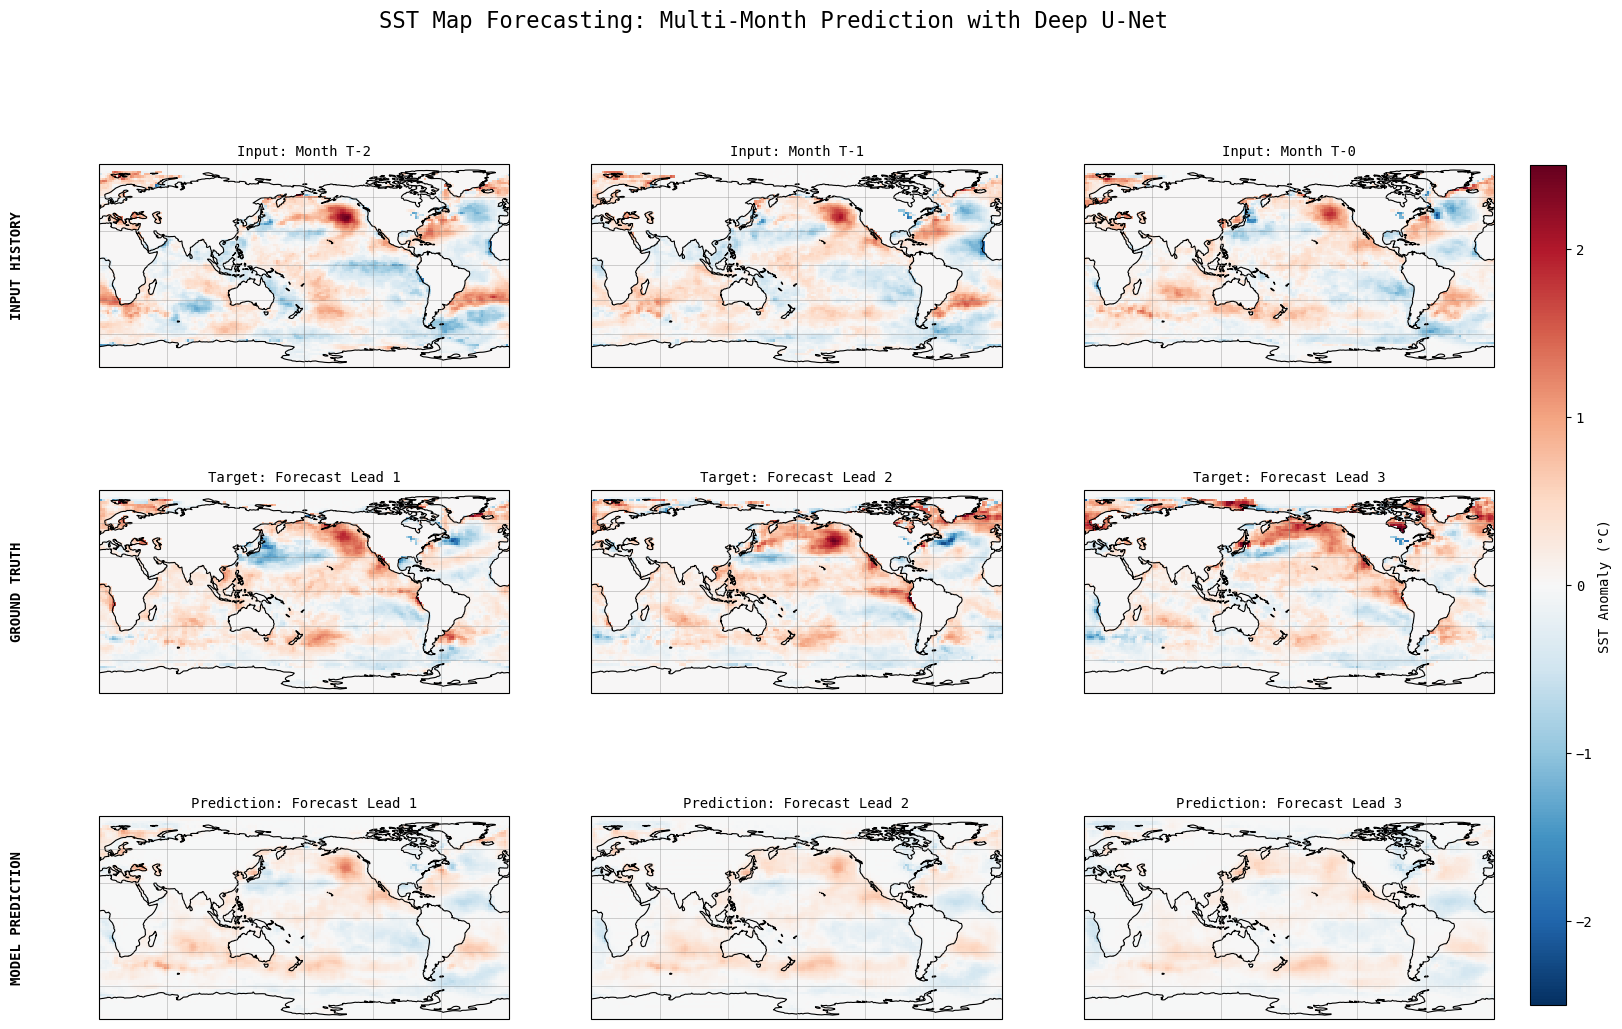

In [20]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

pl_unet_map.eval()
test_sample_idx = 0

with torch.no_grad():
    x, _, y_map = test_dataset_2d[test_sample_idx]
    # x: (12, Lat, Lon), y_map: (3, Lat, Lon)
    pred_map = pl_unet_map(x.unsqueeze(0)).squeeze(0) # (3, Lat, Lon)

# Setup Projection
proj = ccrs.PlateCarree(central_longitude=180)
fig, axes = plt.subplots(3, 3, figsize=(18, 12), subplot_kw={'projection': proj})

def plot_sst(ax, data_tensor, title):
    # Wrap in DataArray to use lat/lon from original dataset
    da = xr.DataArray(data_tensor.numpy(), coords={'lat': ds.lat, 'lon': ds.lon}, dims=('lat', 'lon'))
    
    im = da.plot(ax=ax, transform=ccrs.PlateCarree(), 
                 cmap='RdBu_r', vmin=-2.5, vmax=2.5, add_colorbar=False)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.6)
    ax.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.5)
    ax.set_title(title, fontsize=10)
    return im

# Row 1: Inputs (Last 3 months of history)
for i in range(3):
    month_idx = 12 - (3-i)
    plot_sst(axes[0, i], x[month_idx], f"Input: Month T-{2-i}")
axes[0, 0].text(-0.2, 0.5, 'INPUT HISTORY', va='center', ha='center', 
                rotation='vertical', transform=axes[0, 0].transAxes, fontweight='bold')

# Row 2: Targets (Next 3 months)
for i in range(3):
    plot_sst(axes[1, i], y_map[i], f"Target: Forecast Lead {i+1}")
axes[1, 0].text(-0.2, 0.5, 'GROUND TRUTH', va='center', ha='center', 
                rotation='vertical', transform=axes[1, 0].transAxes, fontweight='bold')

# Row 3: Predictions
for i in range(3):
    im = plot_sst(axes[2, i], pred_map[i], f"Prediction: Forecast Lead {i+1}")
axes[2, 0].text(-0.2, 0.5, 'MODEL PREDICTION', va='center', ha='center', 
                rotation='vertical', transform=axes[2, 0].transAxes, fontweight='bold')

# Common Colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = plt.colorbar(im, cax=cbar_ax, label='SST Anomaly (°C)')

plt.suptitle("SST Map Forecasting: Multi-Month Prediction with Deep U-Net", fontsize=16)
plt.show()